测试数据和训练数据分组，数据分batch

In [19]:
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
# 参数与配置
torch.manual_seed(100)  # 设置随机种子，以使实验结果具有可重复性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有GPU先用GPU训练

# 加载数据集
def dataloader(batch_size, workers=2):
    # 训练集
    train_xdata = load('train_xdata')
    train_ylabel = load('train_ylabel')
    # 验证集
    val_xdata = load('val_xdata')
    val_ylabel = load('val_ylabel')
    # 测试集
    test_xdata = load('test_xdata')
    test_ylabel = load('test_ylabel')

    # 加载数据
    train_loader = Data.DataLoader(dataset=Data.TensorDataset(train_xdata, train_ylabel),
                                   batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    val_loader = Data.DataLoader(dataset=Data.TensorDataset(val_xdata, val_ylabel),
                                 batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    test_loader = Data.DataLoader(dataset=Data.TensorDataset(test_xdata, test_ylabel),
                                  batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    return train_loader, val_loader, test_loader

batch_size = 64
# 加载数据
train_loader, val_loader, test_loader = dataloader(batch_size)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

111
31
15


In [52]:
class CNNTransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers, num_heads, dropout_rate=0.5):
        super(CNNTransformerModel, self).__init__()
        """
        修改说明：
        1. 新增CNN特征提取模块
        2. 调整Transformer输入维度匹配CNN输出
        3. 保持后续结构不变
        """
        # CNN特征提取模块（网页2、4、6的核心思想）
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=7, padding=3),  # 保持序列长度
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),  # 1024 -> 512
            nn.Conv1d(16, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),  # 512 -> 256
            nn.Conv1d(128, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=8)  # 256 -> 32
        )
        
        # Transformer模块（保持原结构，网页1、5的设计）
        self.transformer = TransformerEncoder(
            TransformerEncoderLayer(d_model=32, nhead=num_heads, dim_feedforward=hidden_dim, 
                                   dropout=dropout_rate, batch_first=True),
            num_layers=num_layers
        )
        
        # 后续结构保持不变（网页2的通用设计）
        self.norm = nn.LayerNorm(32)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(32, output_dim)

    def forward(self, input_seq):
        # 新增CNN处理流程（网页3、7的实现方式）
        batch_size = input_seq.size(0)
        
        # 添加通道维度并处理（B,1024）->（B,1,1024）
        x = input_seq.unsqueeze(1)  
        
        # CNN特征提取（网页6的典型结构）
        x = self.cnn(x)  # 输出形状：(B,32,32)
        
        # 维度调整匹配Transformer输入（网页9的格式要求）
        x = x.transpose(1, 2)  # (B,32,32) -> (B,32,32)
        
        # Transformer处理（保持原结构）
        x = self.transformer(x)
        x = self.norm(x)
        
        # 分类头处理（通用结构）
        x = self.avgpool(x.transpose(1, 2))  # (B,32,1)
        x = x.view(batch_size, -1)
        return self.fc(x)

# 参数配置（需与CNN输出维度匹配）
input_dim = 32  # 对应CNN输出通道数
hidden_dim = 128
output_dim = 5   
num_layers = 4
num_heads = 8

# 初始化模型
model = CNNTransformerModel(input_dim, output_dim, hidden_dim, num_layers, num_heads)
loss_function = nn.CrossEntropyLoss(reduction='sum')  # loss
learn_rate = 0.0003
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)  # 优化器
# 看下这个网络结构总共有多少个参数
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

   112
    16
 10240
   128
 12288
    32
  3072
    96
  1024
    32
  4096
   128
  4096
    32
    32
    32
    32
    32
  3072
    96
  1024
    32
  4096
   128
  4096
    32
    32
    32
    32
    32
  3072
    96
  1024
    32
  4096
   128
  4096
    32
    32
    32
    32
    32
  3072
    96
  1024
    32
  4096
   128
  4096
    32
    32
    32
    32
    32
    32
    32
   160
     5
______
 73861


In [53]:
print(model)

CNNTransformerModel(
  (cnn): Sequential(
    (0): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(128, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=128, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=128, out_features=32, bias=True)
 

Epoch:  1 train_Loss: 1.61996531 train_Accuracy:0.2038
Epoch:  1 val_Loss:1.61165245,  validate_Acc:0.2092
Epoch:  2 train_Loss: 1.61432903 train_Accuracy:0.2019
Epoch:  2 val_Loss:1.61054448,  validate_Acc:0.1925
Epoch:  3 train_Loss: 1.61335855 train_Accuracy:0.1978
Epoch:  3 val_Loss:1.61055710,  validate_Acc:0.1930
Epoch:  4 train_Loss: 1.61414689 train_Accuracy:0.2000
Epoch:  4 val_Loss:1.61469408,  validate_Acc:0.2092
Epoch:  5 train_Loss: 1.61224523 train_Accuracy:0.2009
Epoch:  5 val_Loss:1.60925191,  validate_Acc:0.2132
Epoch:  6 train_Loss: 1.61004374 train_Accuracy:0.2142
Epoch:  6 val_Loss:1.60823244,  validate_Acc:0.1910
Epoch:  7 train_Loss: 1.58993459 train_Accuracy:0.2454
Epoch:  7 val_Loss:1.44162137,  validate_Acc:0.5565
Epoch:  8 train_Loss: 1.32751261 train_Accuracy:0.3905
Epoch:  8 val_Loss:1.10213921,  validate_Acc:0.4234
Epoch:  9 train_Loss: 0.86525112 train_Accuracy:0.6075
Epoch:  9 val_Loss:0.71634354,  validate_Acc:0.6512
Epoch: 10 train_Loss: 0.67588981 trai

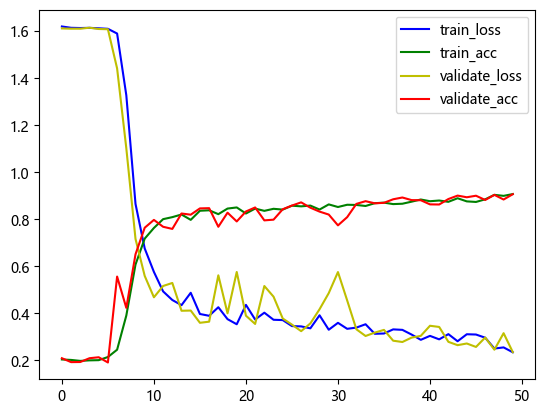

best_accuracy : 0.9067540322580645


In [54]:
# 训练模型
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc("font", family='Microsoft YaHei')

def model_train(batch_size, epochs, model, optimizer, loss_function, train_loader, val_loader):
    model = model.to(device)
    # 样本长度
    train_size = len(train_loader) * batch_size
    val_size = len(val_loader) * batch_size

    # 最高准确率  最佳模型
    best_accuracy = 0.0
    best_model = model

    train_loss = []     # 记录在训练集上每个epoch的loss的变化情况
    train_acc = []    # 记录在训练集上每个epoch的准确率的变化情况
    validate_acc = []
    validate_loss = []

    # 计算模型运行时间
    start_time = time.time()
    for epoch in range(epochs):
        # 训练
        model.train()

        loss_epoch = 0.    #保存当前epoch的loss和
        correct_epoch = 0  #保存当前epoch的正确个数和
        for seq, labels in train_loader: 
            seq, labels = seq.to(device), labels.to(device)
            # print(seq.size(), labels.size()) torch.Size([32, 7, 1024]) torch.Size([32])
            # 每次更新参数前都梯度归零和初始化
            optimizer.zero_grad()
            # 前向传播
            y_pred = model(seq)  #   torch.Size([16, 10])
            # 对模型输出进行softmax操作，得到概率分布
            probabilities = F.softmax(y_pred, dim=1)
            # 得到预测的类别
            predicted_labels = torch.argmax(probabilities, dim=1)
            # 与真实标签进行比较，计算预测正确的样本数量  # 计算当前batch预测正确个数
            correct_epoch += (predicted_labels == labels).sum().item()
            # 损失计算
            loss = loss_function(y_pred, labels)
            loss_epoch += loss.item()
            # 反向传播和参数更新
            loss.backward()
            optimizer.step()
        #     break
        # break
        # 计算准确率
        train_Accuracy  = correct_epoch/train_size 
        train_loss.append(loss_epoch/train_size)
        train_acc.append(train_Accuracy)
        print(f'Epoch: {epoch+1:2} train_Loss: {loss_epoch/train_size:10.8f} train_Accuracy:{train_Accuracy:4.4f}')
        # 每一个epoch结束后，在验证集上验证实验结果。
        with torch.no_grad():
            # 将模型设置为评估模式
            model.eval()
            loss_validate = 0.
            correct_validate = 0
            for data, label in val_loader:
                data, label = data.to(device), label.to(device)
                pre = model(data)
                # 对模型输出进行softmax操作，得到概率分布
                probabilities = F.softmax(pre, dim=1)
                # 得到预测的类别
                predicted_labels = torch.argmax(probabilities, dim=1)
                # 与真实标签进行比较，计算预测正确的样本数量  # 计算当前batch预测正确个数
                correct_validate += (predicted_labels == label).sum().item()
                loss = loss_function(pre, label)
                loss_validate += loss.item()
            # print(f'validate_sum:{loss_validate},  validate_Acc:{correct_validate}')
            val_accuracy = correct_validate/val_size 
            print(f'Epoch: {epoch+1:2} val_Loss:{loss_validate/val_size:10.8f},  validate_Acc:{val_accuracy:4.4f}')
            validate_loss.append(loss_validate/val_size)
            validate_acc.append(val_accuracy)
            # 如果当前模型的准确率优于之前的最佳准确率，则更新最佳模型
            #保存当前最优模型参数
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_model = model# 更新最佳模型的参数

    
    # 保存最后的参数
    # torch.save(model, 'final_model_transformer.pt')
    # 保存最好的参数
    torch.save(best_model, 'best_model_cnn_transformer.pt')
   
    print(f'\nDuration: {time.time() - start_time:.0f} seconds')
    plt.plot(range(epochs), train_loss, color = 'b',label = 'train_loss')
    plt.plot(range(epochs), train_acc, color = 'g',label = 'train_acc')
    plt.plot(range(epochs), validate_loss, color = 'y',label = 'validate_loss')
    plt.plot(range(epochs), validate_acc, color = 'r',label = 'validate_acc')
    plt.legend()
    plt.show()   #显示 lable 
    print("best_accuracy :", best_accuracy)



batch_size = 64
epochs = 50
# 模型训练
model_train(batch_size, epochs, model, optimizer, loss_function, train_loader, val_loader)

In [51]:
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
# 模型 测试集 验证  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有GPU先用GPU训练
#device = torch.device("cpu") # 有GPU先用GPU训练
# 得出每一类的分类准确率
model = torch.load('best_model_cnn_transformer.pt')
model = model.to(device)

# 使用测试集数据进行推断并计算每一类的分类准确率
class_labels = []  # 存储类别标签
predicted_labels = []  # 存储预测的标签

with torch.no_grad():
    for test_data, test_label in test_loader:
        # 将模型设置为评估模式
        model.eval()
        test_data = test_data.to(device)
        test_output = model(test_data)
        probabilities = F.softmax(test_output, dim=1)
        predicted = torch.argmax(probabilities, dim=1)
        
        class_labels.extend(test_label.tolist())
        predicted_labels.extend(predicted.tolist())

# 混淆矩阵
confusion_mat = confusion_matrix(class_labels, predicted_labels)

from sklearn.metrics import classification_report
# 计算每一类的分类准确率
report = classification_report(class_labels, predicted_labels, digits=4)
print(report)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_16564\234985517.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('best_model_cnn_transformer.pt')


              precision    recall  f1-score   support

           0     1.0000    0.9799    0.9898       199
           1     0.7729    0.9365    0.8469       189
           2     0.7963    0.9198    0.8536       187
           3     0.9172    0.8158    0.8635       190
           4     0.9934    0.7692    0.8671       195

    accuracy                         0.8844       960
   macro avg     0.8960    0.8842    0.8842       960
weighted avg     0.8979    0.8844    0.8852       960



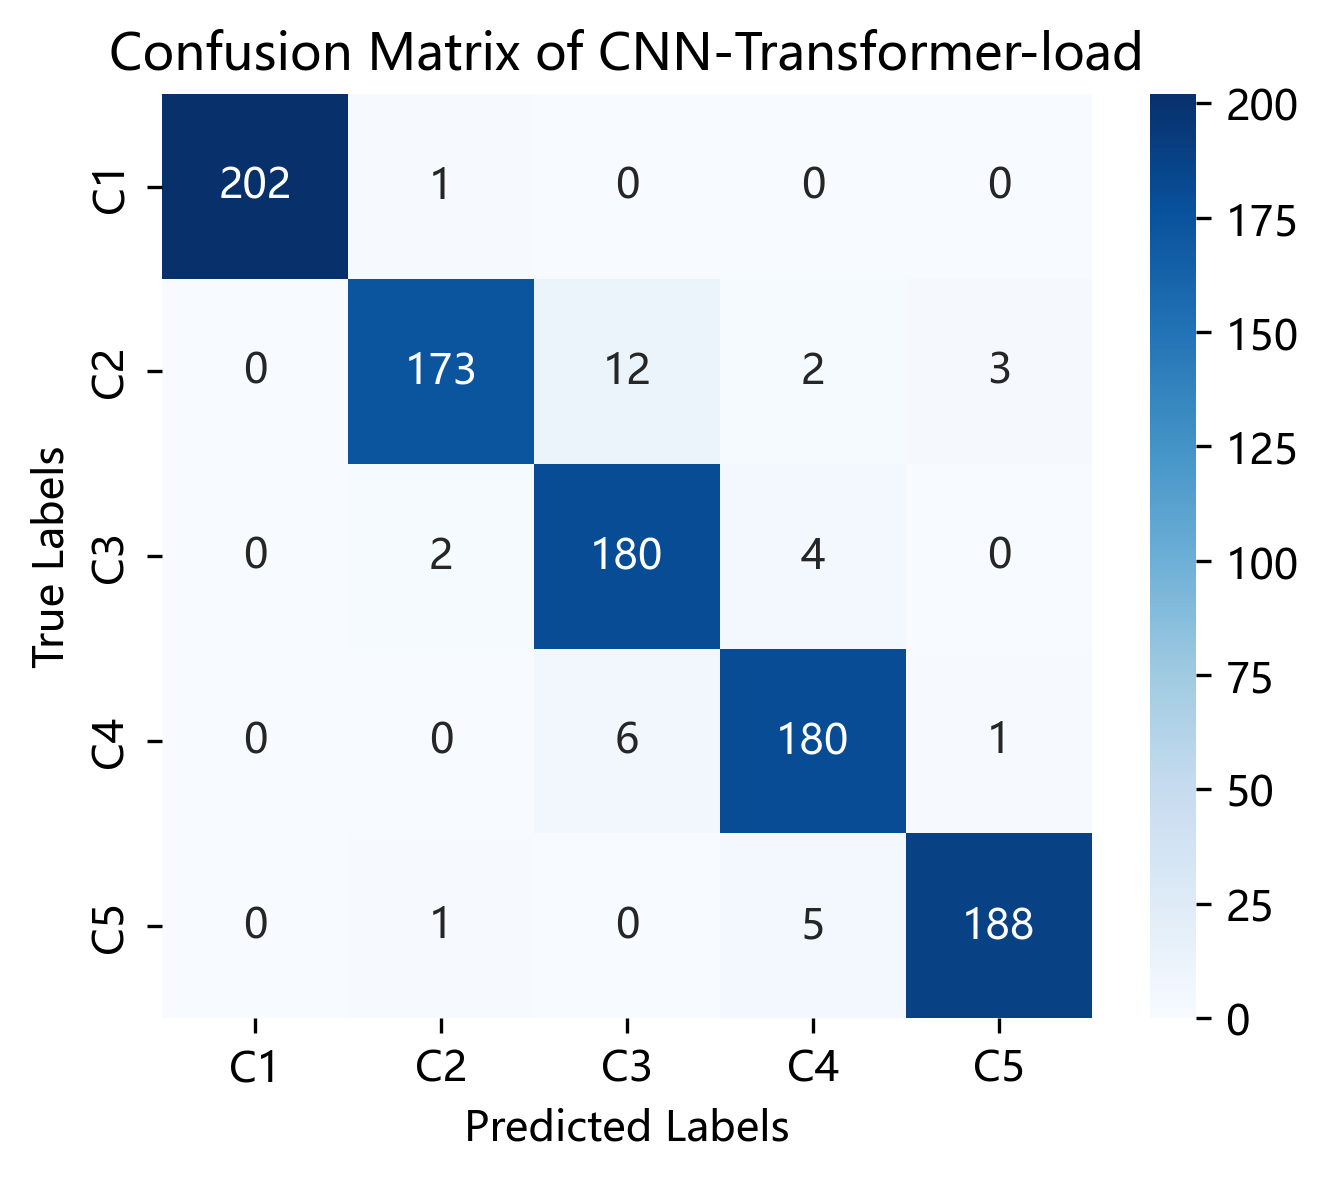

In [34]:
# 绘制混淆矩阵
import matplotlib.pyplot as plt
import seaborn as sns
# 原始标签和自定义标签的映射
label_mapping = {
    0: "C1",1: "C2",2: "C3",3: "C4",4: "C5",
    #5: "C6",6: "C7",7: "C8",8: "C9",9: "C10",
}

# 绘制混淆矩阵
plt.figure(figsize=(5, 4), dpi=300)
sns.heatmap(confusion_mat,  xticklabels=label_mapping.values(), yticklabels=label_mapping.values(),annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of CNN-Transformer-load')
plt.savefig("CNN-Transformer_confusion.png")
plt.show()